In [1]:
# !pip install ipywidgets widgetsnbextension pandas-profiling

In [2]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
# import seaborn as sns
# import random
import torch
import numpy as np
from tqdm import tqdm

In [3]:
# GOOGL

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2000-01-01'  # '2014-01-01'  # 2012-10-21
end_date = '2022-11-22'  # '2014-10-20'  # 2022

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader('IBM', 'yahoo', start_date, end_date)

# Resample the data to normalize it, the data comes without any data on the (days that the markets are close, weekends)
panel_data = panel_data.resample("D").max()

# Fill the data in the closed markets with the data from the previous trading day, because it is their true value
panel_data = panel_data.fillna(method="ffill")

panel_data[panel_data.index.name] = panel_data.index
panel_data.index.name = None
panel_data = panel_data[['Date', 'High', 'Low', 'Open', 'Close', 'Volume']]  # , 'Adj Close']]
panel_data.reset_index(drop=True, inplace=True)

# panel_data.head(20)

In [4]:
date = pd.to_datetime(panel_data.pop('Date'), format='%Y-%m-%d')

In [5]:
plot_cols = ['High', 'Low', 'Open', 'Close', 'Volume']  # , 'Adj Close']
# plot_cols = ['High', 'Low', 'Open', 'Close', 'Adj Close']
plot_features = panel_data[plot_cols]
plot_features.index = date
# _ = plot_features.plot(subplots=True)


In [6]:
# panel_data.describe().transpose()

In [7]:
# panel_data.drop(columns=['Volume'], axis=1, inplace=True)
# panel_data

In [8]:
# Calculate percentage change

panel_data['Open'] = panel_data['Open'].pct_change()
panel_data['High'] = panel_data['High'].pct_change()
panel_data['Low'] = panel_data['Low'].pct_change()
panel_data['Close'] = panel_data['Close'].pct_change()
# panel_data['Adj Close'] = panel_data['Adj Close'].pct_change()

panel_data['Volume'] = panel_data['Volume'].pct_change()
panel_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
# panel_data

In [9]:
# Normalize price columns
min_return = min(panel_data[['Open', 'High', 'Low', 'Close']].min(axis=0)) # , 'Adj Close'
max_return = max(panel_data[['Open', 'High', 'Low', 'Close']].max(axis=0)) # , 'Adj Close'

# Min-max normalize price columns (0-1 range)
panel_data['Open'] = (panel_data['Open'] - min_return) / (max_return - min_return)
panel_data['High'] = (panel_data['High'] - min_return) / (max_return - min_return)
panel_data['Low'] = (panel_data['Low'] - min_return) / (max_return - min_return)
panel_data['Close'] = (panel_data['Close'] - min_return) / (max_return - min_return)
# panel_data['Adj Close'] = (panel_data['Adj Close'] - min_return) / (max_return - min_return)


# Normalize volume column
min_volume = panel_data['Volume'].min(axis=0)
max_volume = panel_data['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
panel_data['Volume'] = (panel_data['Volume'] - min_volume) / (max_volume - min_volume)


In [10]:
# Create training, validation and test split
times = sorted(panel_data.index.values)
last_10pct = sorted(panel_data.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(panel_data.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = panel_data[(panel_data.index < last_20pct)]  # Training data are 80% of total data
df_val = panel_data[(panel_data.index >= last_20pct) & (panel_data.index < last_10pct)]
df_test = panel_data[(panel_data.index >= last_10pct)]

In [11]:
# # Remove date column
# df_train.drop(columns=['Date'], inplace=True)
# df_val.drop(columns=['Date'], inplace=True)
# df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print(f'Training data shape: {train_data.shape}')
print(f'Validation data shape: {val_data.shape}')
print(f'Test data shape: {test_data.shape}')

Training data shape: (6688, 5)
Validation data shape: (836, 5)
Test data shape: (835, 5)


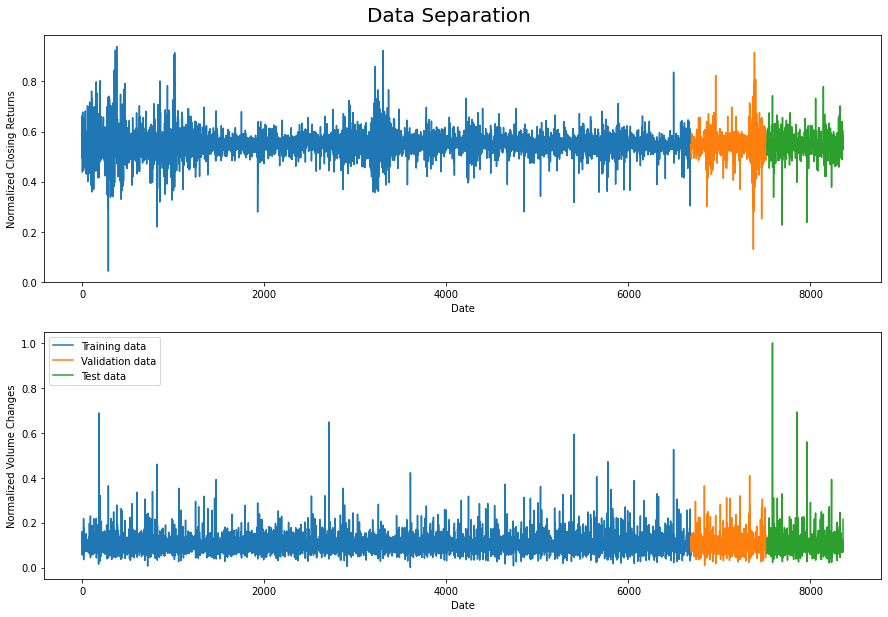

In [12]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

In [13]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random, math

### Set device

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [35]:
sequence_length = 128  # [sequence_length] sequences of [input_size] features
input_size = 5
num_layers = 2
hidden_size = 256
num_features = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 10

input_width = 5
target_width = 3

### Create Bidirectional LSTM

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_features):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True -> first layer that takes in the DataSet
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_features)
    
    def forward(self, x):
        # h0 = hidden state
        # c0 = cell state
        # self.num_layers * 2 -> tensor expanded x2 for concatenated state values of "going from begining to end and end to begining"
        # x.size(0) = number of examples sent in -> batch size
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, (hiddenState, cellState) = self.lstm(x, (h0, c0))  # (hiddenState, cellState) are not used -> can be replaced as _
        # out[:, -1, :] -> select the last hidden state to send to the linear layer
        # [:, -1, :] -> [all training examples, last hidden state, all the features]
        # out = out.reshape(out.shape[0], -1)
        out = self.fc(out[:, -1, :])

        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers * 2, batch_size, self.hidden_size).zero_().to(device),
                      weight.new(self.num_layers * 2, batch_size, self.hidden_size).zero_().to(device))
        return hidden



### Load Data

#### DataSet

In [17]:
# from torch.utils.data import Dataset

In [18]:
class DataSetter(Dataset):
    def __init__(self, data: np.ndarray, seq_len: int) -> None:
        """Init function of dataset class
       Args:
            data (np.ndarray): data from the dataframe to numpy
            seq_len (int): len of values to base for the prediction
        """
        self.inputs, self.targets = [], []
        
        for i in range(seq_len, len(data)):
            # Chunks of  data with a length of 128 df-rows
            self.inputs.append(data[i-seq_len:i])
            
            # Value of 4th column (Close Price) of df-row 128+1
            self.targets.append(data[:, 3][i])

        self.inputs, self.targets =\
            torch.FloatTensor(np.array(self.inputs)), torch.FloatTensor(np.array(self.targets))

    def __getitem__(self, idx: int) -> dict:
        """Get item at a certain index
        Args:
            idx (int): index to get the value
        Returns:
            dict: returns the input and the target
        """
        return {'inputs': self.inputs[idx],
                'targets': self.targets[idx]}
    
    def __len__(self) -> int:
        """Length function
        Returns:
            int: length of the Dataset
        """
        return min(len(self.inputs), len(self.targets))

In [19]:
train_dataset = DataSetter(data=train_data, seq_len=sequence_length)
val_dataset = DataSetter(data=val_data, seq_len=sequence_length)
test_dataset = DataSetter(data=test_data, seq_len=sequence_length)

#### DataLoader

In [20]:
# from torch.utils.data import DataLoader

In [21]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Intitialize network

In [25]:
model = BiLSTM(input_size, hidden_size, num_layers, num_features).to(device)

In [26]:
print(model)

BiLSTM(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


### Loss and optimizer

In [27]:
# import torch.optim as optim

In [28]:
criterion = nn.MSELoss()  # nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Network

In [29]:
# import math
# n_iterations = math.ceil(len(train_dataset)/4)

counter = 0
print_every = 1
valid_loss_min = np.Inf


# loss_train = []
model.train()
for epoch in range(num_epochs):
    train_losses = []
    for batch_idx, (data_combo) in enumerate(train_loader):
        # counter += 1


        # Identify Data
        data_in = data_combo['inputs']
        targets = data_combo['targets']
        
        
        # Forward Backward
        # if (batch_idx+1) % 5 == 0:
        #     print(f'epoch {epoch + 1}/{num_epochs}, step {batch_idx + 1}/{100}, inputs {data_in.shape}')
        
        # Get data to CUDA device
        data_in = data_in.to(device=device)#.squeeze(1)
        targets = targets.to(device=device).unsqueeze(1)
        # print(data_in.size(), data_in)

        # # Get to correct shape
        # data_in = data_in.reshape(data_in.shape[0], -1)

        # forward
        scores = model(data_in)
        # print(scores, targets)
        # print(scores.size(), targets.size())
        loss = criterion(scores, targets)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or Adam step
        optimizer.step()

        # loss_train.append(loss.item())

    # model.eval()

    # targ_pred = model(data_in)
    # val_loss = criterion

        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            
            model.eval()
            for data_combo_2 in val_loader:
                inp, lab = data_combo_2['inputs'], data_combo_2['targets']
                inp, lab = inp.to(device), lab.to(device)
                # print(lab)
                out = model(inp)
                # val_h = tuple([each.data for each in val_h])
                # val_h = model(val_h)
                # out, val_h = model(inp, val_h)

                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()

            if np.mean(val_losses) <= valid_loss_min:
                print(f"Epoch: {epoch + 1}/{num_epochs}...",
                    f"Step: {batch_idx + 1}/{100}...",
                    f"Loss: {loss.item():.6f}...",
                    f"Val Loss: {np.mean(val_losses):.6f}")
                torch.save(model.state_dict(), 'LSTM_Models//state_dict.pt')  # save model state (wights, etc.)
                torch.save(model, 'LSTM_Models//model_complete.pt')  # save complete model
                print(f'Validation loss decreased ({valid_loss_min:.6f} --> {np.mean(val_losses):.6f}).  Saving model ...')
                valid_loss_min = np.mean(val_losses)



Epoch: 1/10... Step: 1/100... Loss: 0.361187... Val Loss: 0.240277
Validation loss decreased (inf --> 0.240277).  Saving model ...
Epoch: 1/10... Step: 2/100... Loss: 0.250306... Val Loss: 0.139451
Validation loss decreased (0.240277 --> 0.139451).  Saving model ...
Epoch: 1/10... Step: 3/100... Loss: 0.142735... Val Loss: 0.047677
Validation loss decreased (0.139451 --> 0.047677).  Saving model ...
Epoch: 1/10... Step: 4/100... Loss: 0.058850... Val Loss: 0.005208
Validation loss decreased (0.047677 --> 0.005208).  Saving model ...
Epoch: 1/10... Step: 7/100... Loss: 0.027491... Val Loss: 0.003512
Validation loss decreased (0.005208 --> 0.003512).  Saving model ...
Epoch: 1/10... Step: 17/100... Loss: 0.003312... Val Loss: 0.003234
Validation loss decreased (0.003512 --> 0.003234).  Saving model ...
Epoch: 1/10... Step: 25/100... Loss: 0.001126... Val Loss: 0.002996
Validation loss decreased (0.003234 --> 0.002996).  Saving model ...
Epoch: 2/10... Step: 17/100... Loss: 0.002490... Va

### Check accuracy on training & test to see how good our model is

In [30]:
# loading the model parameters (weights, etc.)
# model = torch.load('model//model_complete.pt')
model.load_state_dict(torch.load('LSTM_Models//state_dict.pt'))

<All keys matched successfully>

In [91]:

test_losses = []
test_preds = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for (combo_data_3) in test_loader:
    inputs, labels = combo_data_3['inputs'], combo_data_3['targets']
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    # output, h = model(inputs, h)
    output = model(inputs)
    test_preds.append(output.cpu().detach().numpy())
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
        
print("Test loss: {:.3f}".format(np.mean(test_losses)))

Test loss: 0.002


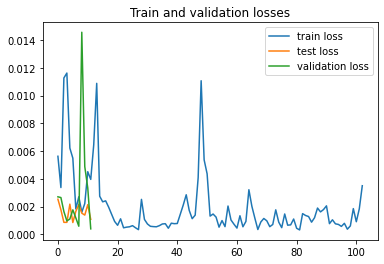

In [32]:
plt.title('Train and validation losses')

plt.plot(range(len(train_losses)), train_losses, label='train loss')
plt.plot(range(len(test_losses)), test_losses, label='test loss')
plt.plot(range(len(val_losses)), val_losses, label='validation loss')
plt.legend()
plt.show()

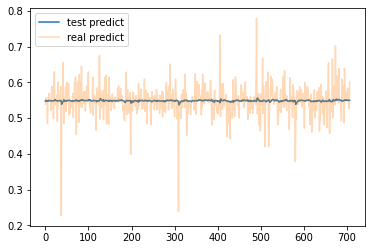

In [94]:
plt.plot(np.concatenate(test_preds, axis=0), label='test predict')
plt.plot(test_loader.dataset[:]['targets'], label= 'real predict', alpha =0.3)
plt.legend()
plt.show()

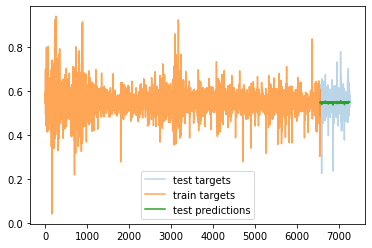

In [106]:
test_predicts = np.concatenate(test_preds, axis=0)
train_targets = train_loader.dataset[:]['targets']
test_targets = test_loader.dataset[:]['targets']

plt.plot(range(len(train_targets), len(train_targets) + len(test_targets)), test_targets, label='test targets', alpha= 0.3)

plt.plot(range(0, len(train_targets)), train_targets, label='train targets', alpha=0.7) 
plt.plot(range(len(train_targets), len(train_targets) + len(test_predicts)), test_predicts, label='test predictions')

plt.legend()
